In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import sys
import matplotlib.pyplot as plt
import seaborn as sns

module_path = (Path().resolve().parent/ "Modules")
sys.path.append(str(module_path))

pd.set_option("display.max_columns", None)

import my_modules, model_tuner, features # 自作モジュール

In [2]:
df = pd.read_csv("../Data/train_data_tmp.csv", encoding="shift-jis")
odds_df = pd.read_csv("../Data/Time_Series_Odds_win_odds.csv", encoding="shift-jis")

In [3]:
df = my_modules.preprocessing(df)

In [4]:
df = my_modules.common_process(df)

C:\Users\ken05\Documents\others\HORSE_RACING\Modules\my_modules.py:76: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["place_num"] = df["place"].replace(place_dict).astype(int)


In [5]:
odds_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252819 entries, 0 to 252818
Data columns (total 22 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   horse_num        252819 non-null  int64  
 1   pre_win_odds_1   252819 non-null  float64
 2   pre_win_odds_2   252819 non-null  float64
 3   pre_win_odds_3   252819 non-null  float64
 4   pre_win_odds_4   252819 non-null  float64
 5   pre_win_odds_5   252819 non-null  float64
 6   pre_win_odds_6   252819 non-null  float64
 7   pre_win_odds_7   252819 non-null  float64
 8   pre_win_odds_8   252819 non-null  float64
 9   pre_win_odds_9   252819 non-null  float64
 10  pre_win_odds_10  252819 non-null  float64
 11  pre_win_odds_11  252774 non-null  float64
 12  pre_win_odds_12  252726 non-null  float64
 13  pre_win_odds_13  252679 non-null  float64
 14  pre_win_odds_14  252622 non-null  float64
 15  pre_win_odds_15  252558 non-null  float64
 16  pre_win_odds_16  252526 non-null  floa

In [6]:
odds_df.head()

,horse_num,pre_win_odds_1,pre_win_odds_2,pre_win_odds_3,pre_win_odds_4,pre_win_odds_5,pre_win_odds_6,pre_win_odds_7,pre_win_odds_8,pre_win_odds_9,pre_win_odds_10,pre_win_odds_11,pre_win_odds_12,pre_win_odds_13,pre_win_odds_14,pre_win_odds_15,pre_win_odds_16,pre_win_odds_17,pre_win_odds_18,pre_win_odds_19,pre_win_odds_20,race_id
0,1,16.1,16.1,16.3,16.3,16.2,16.2,15.8,15.8,15.8,15.9,15.9,15.6,16.0,15.9,17.3,17.0,16.7,17.9,19.6,20.9,202007250101010101
1,2,1.7,1.7,1.7,1.7,1.7,1.7,1.7,1.7,1.7,1.7,1.7,1.7,1.7,1.7,1.8,1.8,1.8,1.8,1.8,1.8,202007250101010102
2,3,2.2,2.2,2.2,2.3,2.3,2.3,2.3,2.2,2.2,2.3,2.3,2.3,2.3,2.2,2.1,2.1,2.1,2.0,2.0,1.9,202007250101010103
3,4,40.2,39.9,40.8,38.7,38.6,37.6,37.5,37.9,37.7,37.7,38.0,38.3,39.6,38.0,40.6,42.0,42.9,46.4,54.6,52.8,202007250101010104
4,5,40.2,40.3,41.3,41.9,41.7,40.6,40.6,41.2,41.5,42.0,41.5,42.2,43.7,43.7,46.9,47.6,48.9,51.5,60.8,61.2,202007250101010105


In [6]:
# オッズデータと結合
merged_df = pd.merge(left=df, right=odds_df, how="left", on=["race_id", "horse_num"])
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252411 entries, 0 to 252410
Data columns (total 94 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   PCI                  251103 non-null  float64       
 1   PCI3                 252411 non-null  float64       
 2   RPCI                 252411 non-null  float64       
 3   race_id              252411 non-null  int64         
 4   year                 252411 non-null  int64         
 5   month                252411 non-null  int64         
 6   day                  252411 non-null  int64         
 7   times                252411 non-null  int64         
 8   place                252411 non-null  object        
 9   daily                252411 non-null  object        
 10  race_num             252411 non-null  int64         
 11  horse                252411 non-null  object        
 12  jockey_id            252411 non-null  object        
 13  trainer_id    

### オッズの予想をしてみる

#### 単勝

In [7]:
df2 = merged_df[["race_id", "id_for_fold"]+[f"pre_win_odds_{i}" for i in range(1, 21)] + ["win_odds"]]
df2.head()

,race_id,id_for_fold,pre_win_odds_1,pre_win_odds_2,pre_win_odds_3,pre_win_odds_4,pre_win_odds_5,pre_win_odds_6,pre_win_odds_7,pre_win_odds_8,pre_win_odds_9,pre_win_odds_10,pre_win_odds_11,pre_win_odds_12,pre_win_odds_13,pre_win_odds_14,pre_win_odds_15,pre_win_odds_16,pre_win_odds_17,pre_win_odds_18,pre_win_odds_19,pre_win_odds_20,win_odds
0,202001050601010115,2020010506010101,254.3,262.4,251.5,241.6,246.4,250.9,253.6,252.3,258.9,254.1,254.7,266.5,272.9,262.0,274.9,287.2,302.5,316.0,355.9,383.5,474.2
1,202001050601010116,2020010506010101,209.0,214.9,198.7,193.5,188.9,188.0,190.2,192.3,198.7,197.1,198.2,205.0,210.7,199.9,207.5,204.8,217.3,217.0,239.5,226.1,233.1
2,202001050601010102,2020010506010101,20.1,20.7,20.9,21.1,21.5,21.7,22.0,22.2,22.6,22.6,23.2,23.8,24.4,24.5,26.1,26.8,28.3,29.0,31.1,34.3,31.4
3,202001050601010104,2020010506010101,21.0,21.6,21.6,21.4,21.6,21.0,20.6,19.9,19.7,19.5,19.1,19.7,19.7,19.1,19.3,18.7,19.1,17.1,15.7,15.0,14.5
4,202001050601010109,2020010506010101,7.0,6.9,6.9,6.8,6.9,6.8,6.8,6.8,6.7,6.8,6.9,7.2,7.1,7.0,6.9,7.0,7.3,7.4,8.0,8.4,9.5


なぜか欠損の場合、オッズが0のものと、np.nanのものが存在するため、pre_win_oddsが0のものは消去して大丈夫だと思われる。

In [101]:
from sklearn.cluster import KMeans
from kneed import KneeLocator


# オッズの特徴量エンジニアリング
# kmeansクラスタリングを用いてオッズの変化をクラスタリングする
def odds_feature_engineering_kmeans(df, N_clusters=None):
    # 欠損値がある行は削除
    df = df.copy()
    df = df.dropna(axis=0)
    # オッズが0（欠損？）の行も削除（投票締め切り100分前にオッズが0になるのは明らかに異常）
    df = df[~(df == 0).any(axis=1)]

    # 特徴量エンジニアリング開始
    # まずは必要な列を抽出
    dict_to_df = dict() # ここに特徴量を格納していく

    # race_id と id_for_foldは加えておく
    dict_to_df["race_id"] = df["race_id"]
    dict_to_df["id_for_fold"] = df["id_for_fold"]

    # 最後3つのオッズも加えておく
    for i in range(18, 21):
        col_name = f"pre_win_odds_{i}"
        dict_to_df[col_name] = df[col_name]

    # 比率(今回のオッズ/前回のオッズ）を使う
    # targetは（確定オッズ/5分前オッズ）
    for i in range(2, 21):
        df[f"pre_win_odds_rate_{i}"] = df[f"pre_win_odds_{i}"] / df[f"pre_win_odds_{i-1}"]
        dict_to_df[f"pre_win_odds_rate_{i}"] = df[f"pre_win_odds_{i}"] / df[f"pre_win_odds_{i-1}"]
    df["target"] = df[f"win_odds"] / df[f"pre_win_odds_{i-1}"]
    dict_to_df["target"] = df[f"win_odds"] / df[f"pre_win_odds_{i-1}"]

    # オッズの変化量を特徴量として加える
    for i in range(18, 21):
        col_name = f"pre_win_odds_diff_{i}"
        dict_to_df[col_name] = df[f"pre_win_odds_rate_{i}"] - df[f"pre_win_odds_rate_{i-1}"]


    # 一度DataFrameに変換
    new_df = pd.DataFrame(dict_to_df)

    # クラスタリングに使う特徴量
    km_cols = [f"pre_win_odds_rate_{i}" for i in range(18, 21)] + \
        [f"pre_win_odds_{i}" for i in range(18, 21)] + \
        [f"pre_win_odds_diff_{i}" for i in range(18, 21)] 
    # クラスタリングに使う特徴量のうち、正規化するもの
    std_cols = [f"pre_win_odds_rate_{i}" for i in range(18, 21)] + \
        [f"pre_win_odds_{i}" for i in range(18, 21)]

    # 標準化
    grouped = new_df.groupby(["id_for_fold"], observed=True)
    for col in std_cols:
        mean = grouped[col].transform("mean")
        std = grouped[col].transform("std")
        new_df[col] = (new_df[col] - mean) / std.replace(0, 1) # 0で割るのを防ぐため

    # pre_win_odds_diffは標準化せず、重みをつけておく
    for col in [f"pre_win_odds_diff_{i}" for i in range(18, 21)]:
        new_df[col] = new_df[col] * 10


    # -- KMeansクラスタリング開始 -- 
    max_clusters = 30
    sse = []
    k_range = range(2, max_clusters + 1)


    display(new_df[km_cols].describe())

    
    for n_clusters in k_range:
        km = KMeans(n_clusters=n_clusters, random_state=42)
        km.fit_predict(new_df[km_cols])
        sse.append(km.inertia_)

    kl = KneeLocator(k_range, sse, curve="convex", direction="decreasing") # KneeLocatorを使うならこれを使う
    best_n_clusters = N_clusters if N_clusters else kl.elbow # 最適なクラスタを自動検出（N_clustersが指定されていない場合）

    # クラスタ数を可視化
    plt.figure(figsize=(10, 6))
    plt.plot(k_range, sse, marker="o")
    plt.axvline(x=best_n_clusters, color="black", linestyle="--", label=f"N_clusters: {best_n_clusters}", alpha=0.5)
    plt.xlabel("Number of Clusters")
    plt.ylabel("SSE")
    plt.title("KMeans Clustering - SSE vs Number of Clusters")
    plt.legend()


    # 最適なクラスタ数で再度KMeansクラスタリング
    km = KMeans(n_clusters=best_n_clusters, random_state=42)
    # もとのDataFrameにクラスタリング結果を追加
    df.loc[:, "odds_cluster"] = km.fit_predict(new_df[km_cols]).astype(str)

    display(df.info())

    return df

#### 特徴量エンジニアリングとして考えられること
#### 全てグループ内で正規化する
- オッズ順位（最後3データ分ぐらい）
- オッズ（レース内で標準化、最後3データ分ぐらい）◎
- TrueSkill
- lifetime_prize
- lifetime_prize_per_race

,pre_win_odds_rate_18,pre_win_odds_rate_19,pre_win_odds_rate_20,pre_win_odds_18,pre_win_odds_19,pre_win_odds_20,pre_win_odds_diff_18,pre_win_odds_diff_19,pre_win_odds_diff_20
count,2.514900e+05,2.514900e+05,2.514900e+05,2.514900e+05,2.514900e+05,2.514900e+05,251490.000000,251490.000000,251490.000000
mean,-9.524900e-17,1.053496e-17,-4.070244e-18,-1.218424e-19,-5.650664e-20,-2.931282e-19,-0.009191,0.158044,0.668432
std,9.614108e-01,9.611192e-01,9.632496e-01,9.632496e-01,9.632496e-01,9.632496e-01,1.029231,1.175250,2.079012
min,-3.989036e+00,-3.940928e+00,-3.590701e+00,-1.733227e+00,-1.693041e+00,-1.651939e+00,-38.876367,-35.220451,-17.821402
25%,-5.954286e-01,-6.332204e-01,-7.088084e-01,-7.016926e-01,-6.964986e-01,-6.725989e-01,-0.547001,-0.505511,-0.429590
50%,1.115766e-01,7.627739e-02,-2.974865e-02,-3.842053e-01,-3.921026e-01,-4.094117e-01,-0.006576,0.063360,0.435310
75%,7.068324e-01,7.106625e-01,7.234912e-01,4.601207e-01,4.502148e-01,3.954437e-01,0.517770,0.726190,1.528287
max,4.006938e+00,4.006938e+00,3.563354e+00,3.816404e+00,3.821498e+00,3.762624e+00,43.670384,27.756236,22.783743


<class 'pandas.core.frame.DataFrame'>
Index: 251490 entries, 0 to 252410
Data columns (total 44 columns):
 #   Column                Non-Null Count   Dtype   
---  ------                --------------   -----   
 0   race_id               251490 non-null  int64   
 1   id_for_fold           251490 non-null  category
 2   pre_win_odds_1        251490 non-null  float64 
 3   pre_win_odds_2        251490 non-null  float64 
 4   pre_win_odds_3        251490 non-null  float64 
 5   pre_win_odds_4        251490 non-null  float64 
 6   pre_win_odds_5        251490 non-null  float64 
 7   pre_win_odds_6        251490 non-null  float64 
 8   pre_win_odds_7        251490 non-null  float64 
 9   pre_win_odds_8        251490 non-null  float64 
 10  pre_win_odds_9        251490 non-null  float64 
 11  pre_win_odds_10       251490 non-null  float64 
 12  pre_win_odds_11       251490 non-null  float64 
 13  pre_win_odds_12       251490 non-null  float64 
 14  pre_win_odds_13       251490 non-null  fl

None

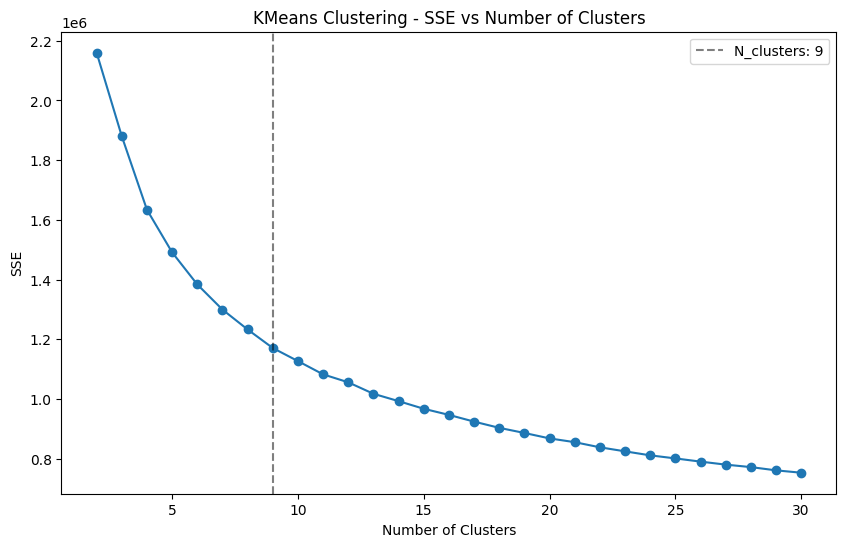

In [102]:
df3 = odds_feature_engineering_kmeans(df2)


# 後で、各クラスタがどのような動き方をするか確認する！
- 標準化した場合
- 標準化していない場合
<br><br>
の両方で考える。

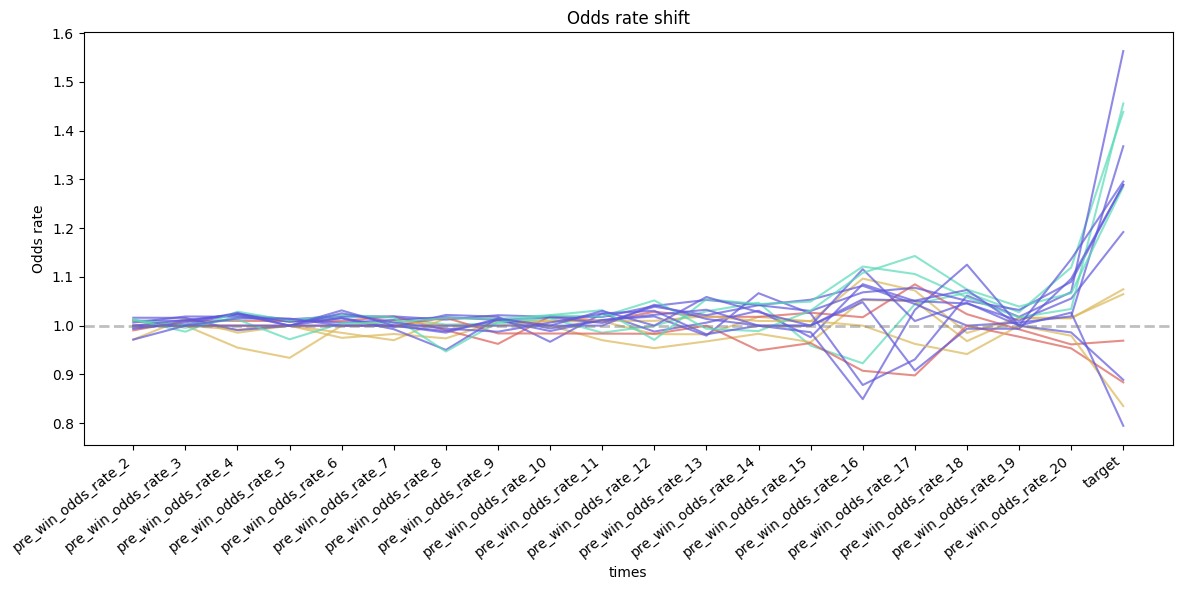

In [103]:
N_data = 16
rand = 14654

# 特徴量のカラム
feature_cols = [f"pre_win_odds_rate_{i}" for i in range(2, 21)] + ["target"]
race_data = df3.iloc[rand:rand + N_data, :]

color_list = sns.color_palette("hls", n_colors=df3["odds_cluster"].nunique())

# 描画
plt.figure(figsize=(12, 6))
for i in range(N_data):
    horse_data = race_data.iloc[i, :]
    c = color_list[int(horse_data["odds_cluster"])]
    plt.plot(horse_data[feature_cols].index, horse_data[feature_cols], color=c, alpha=0.7)


plt.axhline(y=1.0, color='gray', linestyle='--', linewidth=2, alpha=0.5)
plt.xticks(rotation=38, ha="right")
plt.title("Odds rate shift")
plt.xlabel("times")
plt.ylabel("Odds rate")
plt.tight_layout()
plt.show()


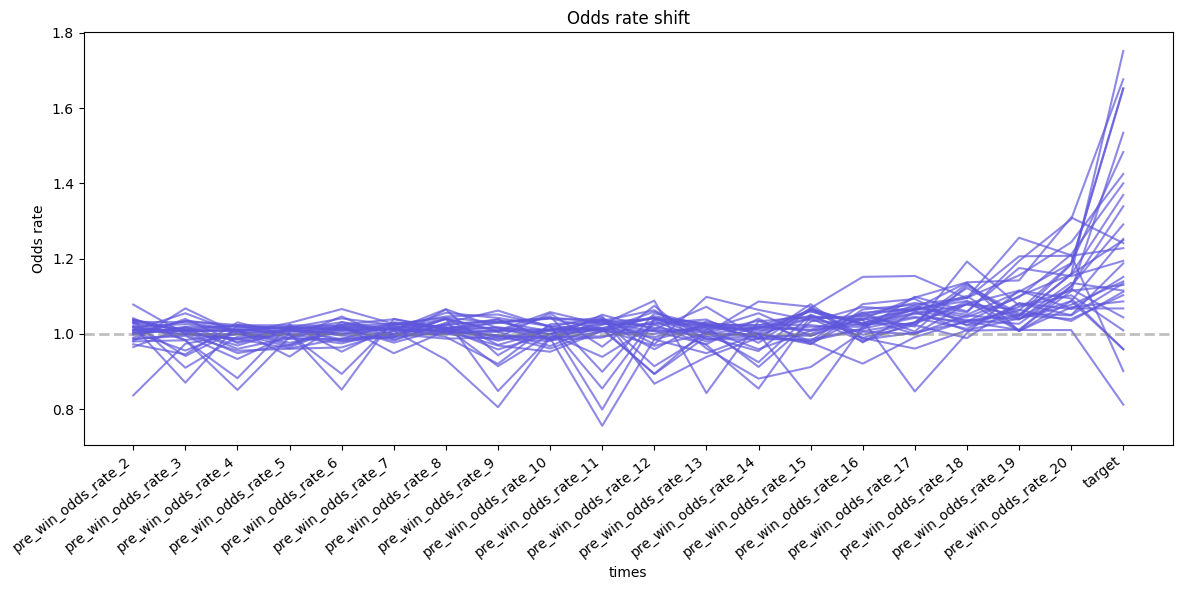

In [104]:
N_data = 32
cluster_num = 2
# 特徴量のカラム
feature_cols = [f"pre_win_odds_rate_{i}" for i in range(2, 21)] + ["target"]
race_data = df3[df3["odds_cluster"] == df3["odds_cluster"].unique()[cluster_num]].head(N_data)

color_list = sns.color_palette("hls", n_colors=df3["odds_cluster"].nunique())

# 描画
plt.figure(figsize=(12, 6))
for i in range(N_data):
    horse_data = race_data.iloc[i, :]
    c = color_list[int(horse_data["odds_cluster"])]
    plt.plot(horse_data[feature_cols].index, horse_data[feature_cols], color=c, alpha=0.7)


plt.axhline(y=1.0, color='gray', linestyle='--', linewidth=2, alpha=0.5)
plt.xticks(rotation=38, ha="right")
plt.title("Odds rate shift")
plt.xlabel("times")
plt.ylabel("Odds rate")
plt.tight_layout()
plt.show()


### pre_win_odds_10 ~ pre_win_odds_20ぐらいを使えばいいのでは...?
下手したら、pre_win_odds_14 ~ pre_win_odds_20位を使えば大丈夫そう 

5分前オッズを使っても、平均して約10%のオッズ変動しかないことに注意!!!

In [112]:
# モデルの学習
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_percentage_error
import lightgbm as lgb

# win_oddsの予測モデル
def win_odds_predict(df_to_copy, params, feature_cols, n_splits=5, random_state=42, early_stopping_rounds=50):
    df = df_to_copy.copy()
    obj_cols = df.select_dtypes(include=["object"]).columns.tolist()
    for col in obj_cols:
        df[col] = df[col].astype("category")

    X, y = df[feature_cols], df["target"]

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    oof_preds = np.zeros(len(X)) # OOF予測値を格納する配列

    print(f"--- LightGBM回帰 (KFold={n_splits}) 学習開始 ---")

    for fold, (train_index, val_index) in enumerate(kf.split(X, y)):
        print(f"\n--- Fold {fold+1}/{n_splits} ---")

        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        # LightGBMのデータセット形式に変換
        lgb_train = lgb.Dataset(X_train, y_train)
        lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)

        # モデルの学習
        model = lgb.train(
            params,
            lgb_train,
            valid_sets=[lgb_eval], # 検証用データセットを指定
            callbacks=[lgb.early_stopping(stopping_rounds=early_stopping_rounds, verbose=False)], # early_stoppingをコールバックとして追加
            # verbose=False にすると学習中のメッセージを非表示にできます
            # verbose=100 などにすると100イテレーションごとに表示されます
        )

        # 検証データに対する予測 (OOF予測)
        oof_preds[val_index] = model.predict(X_val, num_iteration=model.best_iteration)


    # 全体のOOF予測に対する性能評価
    total_mape = np.sqrt(mean_absolute_percentage_error(df["win_odds"], oof_preds * df["pre_win_odds_20"]))
    print(f"\n--- 全体のOOF MAPE: {total_mape:.4f} ---")


    # 特徴量重要度の可視化
    # 特徴量名と重要度を取得
    importance = model.feature_importance(importance_type='gain')  # または 'gain'
    feature_names = np.array(model.feature_name())

    # 重要度の降順でソートするインデックスを取得
    sorted_idx = np.argsort(importance)[::-1]

    # ソートされた特徴量と重要度
    sorted_features = feature_names[sorted_idx]
    sorted_importance = importance[sorted_idx]

    # 棒グラフを描画
    plt.figure(figsize=(24, 6))
    plt.bar(sorted_features, sorted_importance)
    plt.xlabel('Importance')
    plt.title('Feature Importance (split)')
    plt.xticks(fontsize=10, rotation=70, ha="right")
    plt.tight_layout()
    plt.show()

    return oof_preds

--- LightGBM回帰 (KFold=5) 学習開始 ---

--- Fold 1/5 ---

--- Fold 2/5 ---

--- Fold 3/5 ---

--- Fold 4/5 ---

--- Fold 5/5 ---

--- 全体のOOF MAPE: 0.4442 ---


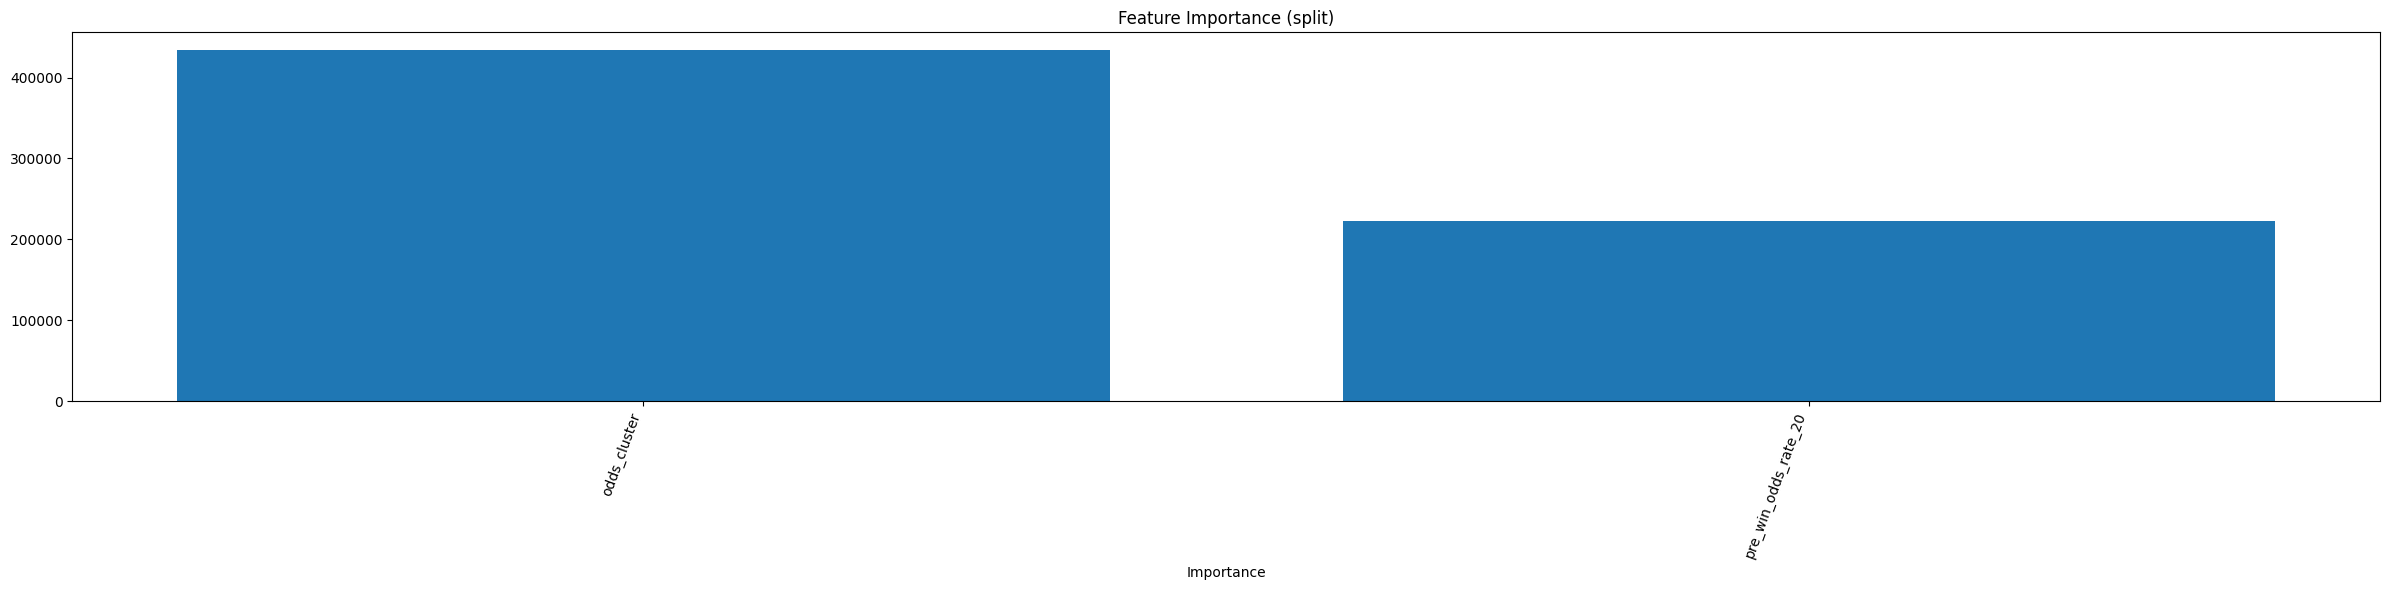

In [117]:
params = {
    "objective": "regression",
    "metric": "mape",
    "max_iterations": 10000,
    "random_state": 42,
    "n_jobs": -1,
    "num_leaves": 80, #重要
    "max_depth": -1,
    "min_data_in_leaf": 1, #重要
    "learning_rate": 0.01,
    "feature_fraction": 0.95,
    "bagging_fraction": 0.99,
    "bagging_freq": 5,
    "verbose": -1,
}
feature_cols = ["odds_cluster"] + ["pre_win_odds_rate_20"]
oof_preds = win_odds_predict(df3, params=params, feature_cols=feature_cols)

In [118]:
oof_preds

array([1.25229394, 1.04619842, 1.19308456, ..., 1.10144132, 0.97662165,
       1.06986626], shape=(251490,))

In [ ]:
df4 = df3.copy()
df4["oof_preds"] = oof_preds

NameError: name 'oof_preds' is not defined

,pre_win_odds_1_log,pre_win_odds_2_log,pre_win_odds_3_log,pre_win_odds_4_log,pre_win_odds_5_log,pre_win_odds_6_log,pre_win_odds_7_log,pre_win_odds_8_log,pre_win_odds_9_log,pre_win_odds_10_log,pre_win_odds_11_log,pre_win_odds_12_log,pre_win_odds_13_log,pre_win_odds_14_log,pre_win_odds_15_log,pre_win_odds_16_log,pre_win_odds_17_log,pre_win_odds_18_log,pre_win_odds_19_log,pre_win_odds_20_log,target,min,max,std,rate_of_pre_odds_2_log,rate_of_pre_odds_3_log,rate_of_pre_odds_4_log,rate_of_pre_odds_5_log,rate_of_pre_odds_6_log,rate_of_pre_odds_7_log,rate_of_pre_odds_8_log,rate_of_pre_odds_9_log,rate_of_pre_odds_10_log,rate_of_pre_odds_11_log,rate_of_pre_odds_12_log,rate_of_pre_odds_13_log,rate_of_pre_odds_14_log,rate_of_pre_odds_15_log,rate_of_pre_odds_16_log,rate_of_pre_odds_17_log,rate_of_pre_odds_18_log,rate_of_pre_odds_19_log,rate_of_pre_odds_20_log,oof_preds
3,3.044522,3.072693,3.072693,3.063391,3.072693,3.044522,3.025291,2.990720,2.980619,2.970414,2.949688,2.980619,2.980619,2.949688,2.960105,2.928524,2.949688,2.839078,2.753661,2.708050,2.674149,2.708050,3.072693,3.072693,1.009253,1.000000,0.996973,1.003037,0.990832,0.993683,0.988573,0.996623,0.996576,0.993022,1.010486,1.000000,0.989623,1.003531,0.989331,1.007227,0.962501,0.969914,0.983436,2.741443
4,1.945910,1.931521,1.931521,1.916923,1.931521,1.916923,1.916923,1.916923,1.902108,1.916923,1.931521,1.974081,1.960095,1.945910,1.931521,1.945910,1.987874,2.001480,2.079442,2.128232,2.251292,1.902108,2.128232,2.128232,0.992606,1.000000,0.992442,1.007616,0.992442,1.000000,1.000000,0.992271,1.007789,1.007616,1.022034,0.992915,0.992763,0.992606,1.007449,1.021565,1.006844,1.038952,1.023463,2.110350
9,0.530628,0.530628,0.530628,0.530628,0.530628,0.530628,0.530628,0.530628,0.530628,0.530628,0.530628,0.530628,0.530628,0.530628,0.470004,0.530628,0.530628,0.470004,0.470004,0.470004,0.470004,0.470004,0.530628,0.530628,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.885749,1.128988,1.000000,0.885749,1.000000,1.000000,0.552637
12,2.721295,2.727853,2.701361,2.714695,2.721295,2.734368,2.727853,2.721295,2.740840,2.734368,2.694627,2.714695,2.708050,2.674149,2.727853,2.714695,2.778819,2.766319,2.778819,2.785011,2.844909,2.674149,2.785011,2.785011,1.002410,0.990288,1.004936,1.002431,1.004804,0.997617,0.997596,1.007182,0.997638,0.985466,1.007447,0.997552,0.987481,1.020083,0.995176,1.023621,0.995502,1.004519,1.002228,2.778983
13,1.335001,1.335001,1.335001,1.335001,1.335001,1.335001,1.335001,1.360977,1.335001,1.335001,1.308333,1.308333,1.308333,1.308333,1.386294,1.360977,1.308333,1.386294,1.435085,1.386294,1.280934,1.308333,1.435085,1.435085,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.019457,0.980914,1.000000,0.980024,1.000000,1.000000,1.000000,1.059588,0.981737,0.961319,1.059588,1.035195,0.966002,1.372418


Text(0, 0.5, 'Odds')

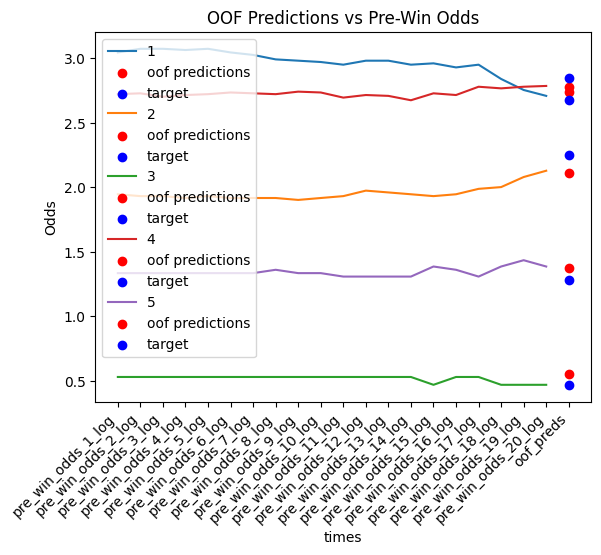

In [ ]:
threshould = 3

race_data = df4.iloc[:16, :]
race_data = race_data[race_data["target"] < threshould]
feature_cols = [f"pre_win_odds_{i}_log" for i in range(1, 21)]


display(race_data.head())
for i in range(len(race_data)):
    horse_data = race_data.iloc[i, :] 
    plt.plot(horse_data[feature_cols].index, horse_data[feature_cols].values, label=f"{i+1}")
    plt.scatter("oof_preds", horse_data["oof_preds"], color="red", label="oof predictions")
    plt.scatter("oof_preds", horse_data["target"], color="blue", label="target")

plt.xticks(rotation=45, ha="right")
plt.legend(loc="upper left") 
plt.title("OOF Predictions vs Pre-Win Odds")
plt.xlabel("times")
plt.ylabel("Odds")